In [13]:
import os
import urllib

from osgeo import gdal
import rasterio as rio
import rasterio.plot
from rasterio.windows import Window
from math import floor, ceil
from pyproj import Proj
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import cartopy.crs as ccrs
import dask
import glob

# Import state vector file using geopandas
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
states_gdf = gpd.read_file(states_url)

%matplotlib inline


prismBaseDir ='/glade/u/home/currierw/work/prism/4km/'
filePpt      = prismBaseDir+'ppt/PRISM_ppt_30yr_normal_4kmM2_10_bil.bil'
fileTmean    = prismBaseDir+'tmean/PRISM_tmean_30yr_normal_4kmM2_10_bil.bil'
fileTmin     = prismBaseDir+'tmin/PRISM_tmin_30yr_normal_4kmM2_10_bil.bil'
fileTmax     = prismBaseDir+'tmax/PRISM_tmax_30yr_normal_4kmM2_10_bil.bil'

lat1,lat2=(30,45)
lon1,lon2=(-117,-103)

def prism2vals(file,lat1,lat2,lon1,lon2):
    with rasterio.open(file) as src:
        row, col  = src.index(lon1, lat1) # spatial --> image coordinates
        row2,col2 = src.index(lon2, lat2) # spatial --> image coordinates
        windowTmp = Window.from_slices(rows=(row2,row),cols=(col, col2))
        arr = src.read(1, window=windowTmp)
        lat = np.arange(lat2,lat1,src.transform[4])
        lon = np.arange(lon1,lon2,src.transform[0])
        arr[arr==-9999]=np.nan
        return arr,lat,lon
    
vals,lat,lon=prism2vals(filePpt,lat1,lat2,lon1,lon2)
ds_P = xr.Dataset({"precipitation":(("lat","lon"),vals)},
              coords={"lat":lat,"lon":lon})

vals,lat,lon=prism2vals(fileTmax,lat1,lat2,lon1,lon2)
ds_Tmax = xr.Dataset({"tmax":(("lat","lon"),vals)},
              coords={"lat":lat,"lon":lon})

vals,lat,lon=prism2vals(fileTmin,lat1,lat2,lon1,lon2)
ds_Tmin = xr.Dataset({"tmin":(("lat","lon"),vals)},
              coords={"lat":lat,"lon":lon})

vals,lat,lon=prism2vals(fileTmean,lat1,lat2,lon1,lon2)
ds_Tmean = xr.Dataset({"tmean":(("lat","lon"),vals)},
              coords={"lat":lat,"lon":lon})

ds_PRISM=xr.merge([ds_P,ds_Tmax,ds_Tmin,ds_Tmean])    
ds_PRISM

dsICAR=xr.open_mfdataset('/glade/scratch/currierw/icar/crb/CCSM4/historical/icar_out_*.nc',combine='by_coords')

df=gpd.read_file('/glade/u/home/currierw/work/shape/crb/b9522000.shp')
df

,AREA,GAGE_NA_ID,STAID,SITEID,NAME,BASIN,MI2,MI2USA,geometry
0,6.197680e+11,9522000,09522000,9522000,"Colorado R at NIB, ab Morelos Dam, nr Andrade,CA",Colo,239292,238186,"POLYGON ((-108.19123 35.12274, -108.19174 35.1..."


Text(0.5, 1.0, 'PRISM October Climatology')

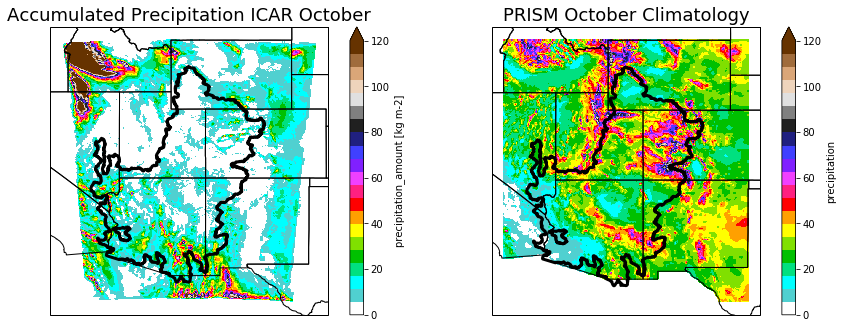

In [2]:
import matplotlib.colors as mcolors

# draw filled contours.
clevs = [0, 1, 2.5, 5, 7.5, 10, 15, 20, 30, 40,
         50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 750]
# In future MetPy
# norm, cmap = ctables.registry.get_with_boundaries('precipitation', clevs)
cmap_data = [(1.0, 1.0, 1.0),
             (0.3137255012989044, 0.8156862854957581, 0.8156862854957581),
             (0.0, 1.0, 1.0),
             (0.0, 0.8784313797950745, 0.501960813999176),
             (0.0, 0.7529411911964417, 0.0),
             (0.501960813999176, 0.8784313797950745, 0.0),
             (1.0, 1.0, 0.0),
             (1.0, 0.6274510025978088, 0.0),
             (1.0, 0.0, 0.0),
             (1.0, 0.125490203499794, 0.501960813999176),
             (0.9411764740943909, 0.250980406999588, 1.0),
             (0.501960813999176, 0.125490203499794, 1.0),
             (0.250980406999588, 0.250980406999588, 1.0),
             (0.125490203499794, 0.125490203499794, 0.501960813999176),
             (0.125490203499794, 0.125490203499794, 0.125490203499794),
             (0.501960813999176, 0.501960813999176, 0.501960813999176),
             (0.8784313797950745, 0.8784313797950745, 0.8784313797950745),
             (0.9333333373069763, 0.8313725590705872, 0.7372549176216125),
             (0.8549019694328308, 0.6509804129600525, 0.47058823704719543),
             (0.6274510025978088, 0.42352941632270813, 0.23529411852359772),
             (0.4000000059604645, 0.20000000298023224, 0.0)]
cmap = mcolors.ListedColormap(cmap_data, 'precipitation')
norm = mcolors.BoundaryNorm(clevs, cmap.N)

ax = plt.axes((0,0,1,1),projection=ccrs.LambertConformal())
dsICAR['precipitation'][-1,:,:].plot(x='lon',y='lat',cmap=cmap,vmin=0,vmax=120,transform=ccrs.LambertConformal(),subplot_kws={'projection': ccrs.LambertConformal()})
ax.add_geometries(states_gdf.geometry, crs = ccrs.LambertConformal(),facecolor='none', edgecolor='black')
ax.add_geometries(df.geometry, crs = ccrs.LambertConformal(),facecolor='none', edgecolor='black',linewidth=3)
ax.set_title('Accumulated Precipitation ICAR October',fontsize=18)

ax = plt.axes((1,0,1,1),projection=ccrs.LambertConformal())
ds_PRISM['precipitation'][:,:].plot(x='lon',y='lat',cmap=cmap,vmin=0,vmax=120,transform=ccrs.LambertConformal(),subplot_kws={'projection': ccrs.LambertConformal()})
ax.add_geometries(states_gdf.geometry, crs = ccrs.LambertConformal(),facecolor='none', edgecolor='black')
ax.add_geometries(df.geometry, crs = ccrs.LambertConformal(),facecolor='none', edgecolor='black',linewidth=3)
ax.set_title('PRISM October Climatology',fontsize=18)

In [14]:
ds_PRISM['tmean']=ds_PRISM['tmean']+273.15

Text(0.5, 1.0, 'PRISM October Climatology')

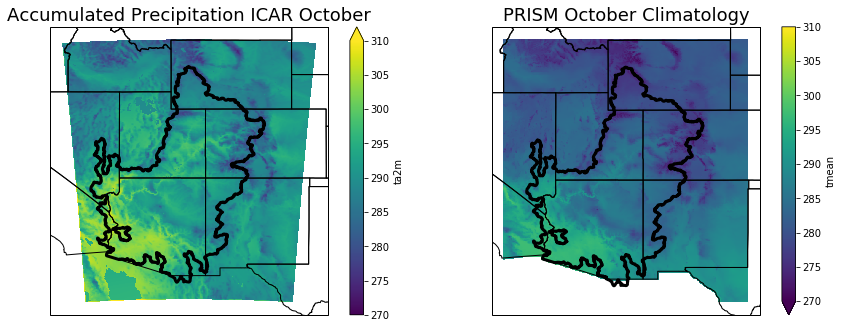

In [16]:
ax = plt.axes((0,0,1,1),projection=ccrs.LambertConformal())
dsICAR['ta2m'].mean(dim='time').plot(x='lon',y='lat',vmin=270,vmax=310,transform=ccrs.LambertConformal(),subplot_kws={'projection': ccrs.LambertConformal()})
ax.add_geometries(states_gdf.geometry, crs = ccrs.LambertConformal(),facecolor='none', edgecolor='black')
ax.add_geometries(df.geometry, crs = ccrs.LambertConformal(),facecolor='none', edgecolor='black',linewidth=3)
ax.set_title('ICAR Mean October Temperature',fontsize=18)


ax = plt.axes((1,0,1,1),projection=ccrs.LambertConformal())
ds_PRISM['tmean'].plot(x='lon',y='lat',vmin=270,vmax=310,transform=ccrs.LambertConformal(),subplot_kws={'projection': ccrs.LambertConformal()})
ax.add_geometries(states_gdf.geometry, crs = ccrs.LambertConformal(),facecolor='none', edgecolor='black')
ax.add_geometries(df.geometry, crs = ccrs.LambertConformal(),facecolor='none', edgecolor='black',linewidth=3)
ax.set_title('PRISM October Climatology',fontsize=18)